In [1]:
import os
import cv2
import sys
import math
import time
# import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch import np
from torch.autograd import Variable

from utils import *
from pose_estimation import *
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 初始化关节参数

In [2]:
# find connection in the specified sequence, center 29 is in the position 15
limb_seq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], 
            [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], 
            [1,16], [16,18], [3,17], [6,18]]
           
# the middle joints heatmap correpondence
map_ids = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], 
           [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], 
           [55,56], [37,38], [45,46]]
          
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], 
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], 
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

In [3]:
use_gpu = True
box_size = 368
scale_search = [0.5, 1.0, 1.5, 2.0]

param_thre1 = 0.1
param_thre2 = 0.05
param_thre3 = 0.5
param_stride = 8

param_thre1, param_thre2, param_thre3

(0.1, 0.05, 0.5)

### 加载模型

In [4]:
state_dict = torch.load('./models/coco_pose_iter_440000.pth.tar')['state_dict']

model = get_pose_model()
model.load_state_dict(state_dict)
model.float()
model.eval()

PoseEstimation (
  (model0): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inplace)
    (18): MaxPool2

### 使用 CUDA

In [5]:
if use_gpu:
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

### 预测图片

CPU times: user 280 ms, sys: 152 ms, total: 432 ms
Wall time: 200 ms


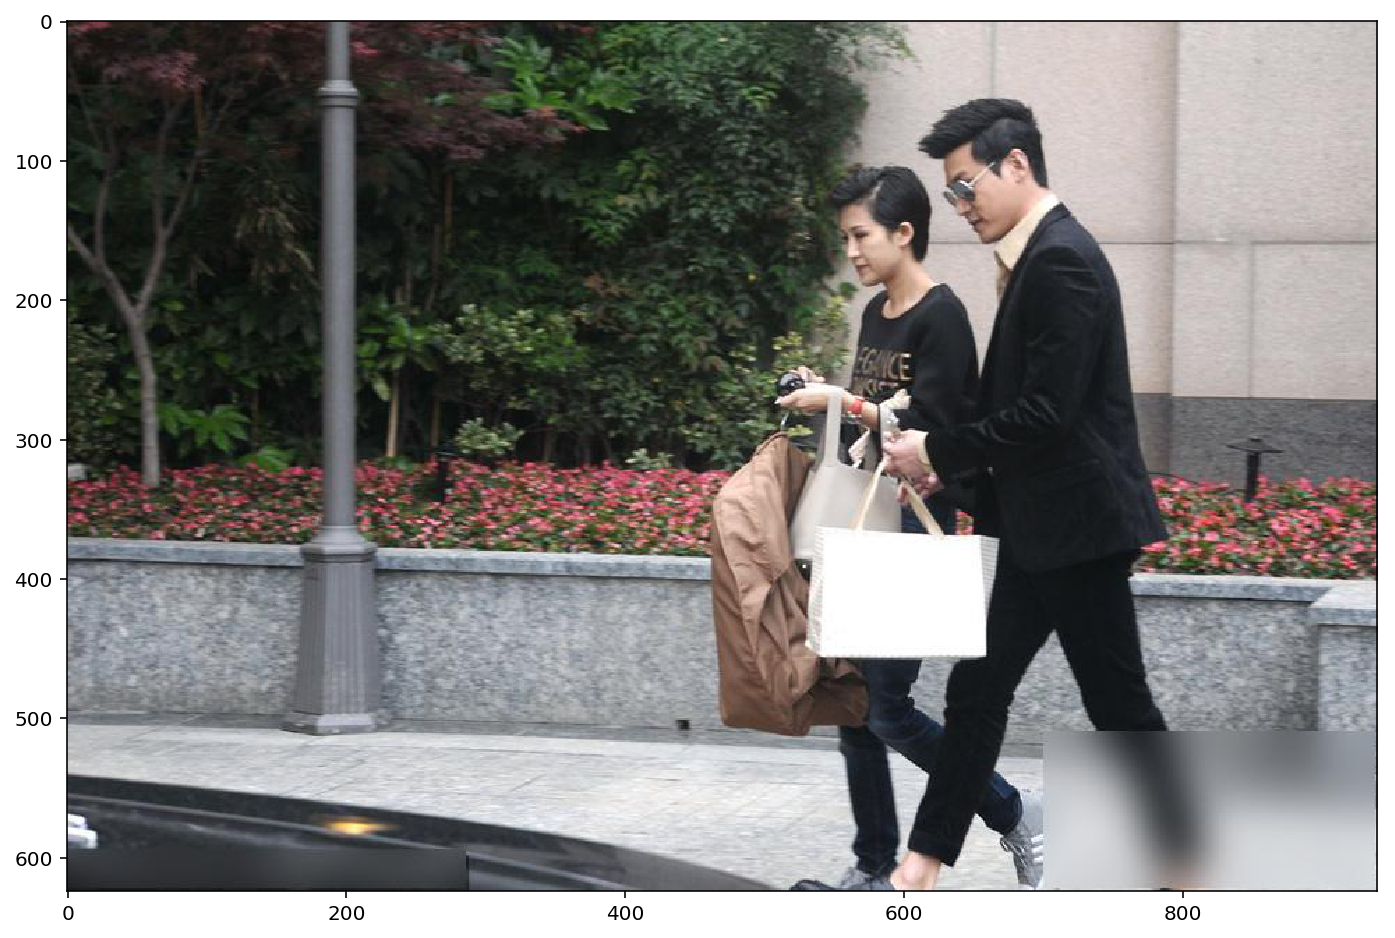

In [6]:
%%time

test_image = './test.jpg'
img_ori = cv2.imread(test_image) # B,G,R order

multiplier = [scale * box_size / img_ori.shape[0] for scale in scale_search]

heatmap_avg = torch.zeros((len(multiplier), 19, img_ori.shape[0], img_ori.shape[1])).cuda()
paf_avg = torch.zeros((len(multiplier), 38, img_ori.shape[0], img_ori.shape[1])).cuda()

# display the validation pics
plt.figure(figsize=(12, 8))
plt.imshow(img_ori[...,::-1])

In [7]:
%%time

for i, scale in enumerate(multiplier):
    h = int(img_ori.shape[0] * scale)
    w = int(img_ori.shape[1] * scale)
    pad_h = 0 if (h % param_stride == 0) else param_stride - (h % param_stride)
    pad_w = 0 if (w % param_stride == 0) else param_stride - (w % param_stride)
    new_h = h + pad_h
    new_w = w + pad_w

    img_test = cv2.resize(img_ori, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    img_test_pad, pad = pad_right_down_corner(img_test, param_stride, param_stride)
    img_test_pad = np.transpose(np.float32(img_test_pad[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5

    feed = Variable(torch.from_numpy(img_test_pad)).cuda()
    output1, output2 = model(feed)
    
    print(output1.size())
    print(output2.size())
    
    heatmap = nn.UpsamplingBilinear2d((img_ori.shape[0], img_ori.shape[1])).cuda()(output2)

    paf = nn.UpsamplingBilinear2d((img_ori.shape[0], img_ori.shape[1])).cuda()(output1)

    heatmap_avg[i] = heatmap[0].data
    paf_avg[i] = paf[0].data

heatmap_avg = torch.transpose(torch.transpose(torch.squeeze(torch.mean(heatmap_avg, 0)), 0, 1), 1, 2).cuda()
paf_avg = torch.transpose(torch.transpose(torch.squeeze(torch.mean(paf_avg, 0)), 0, 1), 1, 2).cuda()
heatmap_avg = heatmap_avg.cpu().numpy()
paf_avg = paf_avg.cpu().numpy()

torch.Size([1, 38, 23, 35])
torch.Size([1, 19, 23, 35])


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


torch.Size([1, 38, 46, 70])
torch.Size([1, 19, 46, 70])
torch.Size([1, 38, 69, 104])
torch.Size([1, 19, 69, 104])
torch.Size([1, 38, 92, 139])
torch.Size([1, 19, 92, 139])
CPU times: user 1.1 s, sys: 2.02 s, total: 3.11 s
Wall time: 7.4 s


In [8]:
%%time

all_peaks = []
peak_counter = 0

for part in range(18):
    map_ori = heatmap_avg[:,:,part]
    map_gau = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map_gau.shape)
    map_left[1:,:] = map_gau[:-1,:]
    map_right = np.zeros(map_gau.shape)
    map_right[:-1,:] = map_gau[1:,:]
    map_up = np.zeros(map_gau.shape)
    map_up[:,1:] = map_gau[:,:-1]
    map_down = np.zeros(map_gau.shape)
    map_down[:,:-1] = map_gau[:,1:]
    
    peaks_binary = np.logical_and.reduce(
        (map_gau >= map_left, map_gau >= map_right, map_gau >= map_up, 
         map_gau >= map_down, map_gau > param_thre1))
    
    peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
    peaks = list(peaks)
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    ids = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (ids[i],) for i in range(len(ids))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 429 ms


In [9]:
%%time

connection_all = []
special_k = []
mid_num = 10

for k in range(len(map_ids)):
    score_mid = paf_avg[:, :, [x - 19 for x in map_ids[k]]]
    candA = all_peaks[limb_seq[k][0] - 1]
    candB = all_peaks[limb_seq[k][1] - 1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limb_seq[k]
    if nA != 0 and nB != 0:
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                vec = np.divide(vec, norm)

                startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num))
                startend = list(startend)

                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(0.5 * img_ori.shape[0] / norm - 1, 0)
                criterion1 = len(np.nonzero(score_midpts > param_thre2)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append(
                        [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0, 5))
        for c in range(len(connection_candidate)):
            i, j, s = connection_candidate[c][0:3]
            if i not in connection[:, 3] and j not in connection[:, 4]:
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if len(connection) >= min(nA, nB):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 149 ms


In [10]:
%%time

# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(map_ids)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limb_seq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 455 µs


In [11]:
# delete some rows of subset which has few parts occur
del_ids = []
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        del_ids.append(i)
subset = np.delete(subset, del_ids, axis=0)

img_canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    for j in range(len(all_peaks[i])):
        cv2.circle(img_canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

stickwidth = 4

In [12]:
for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limb_seq[i])-1]
        if -1 in index:
            continue
        cur_canvas = img_canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        img_canvas = cv2.addWeighted(img_canvas, 0.4, cur_canvas, 0.6, 0)

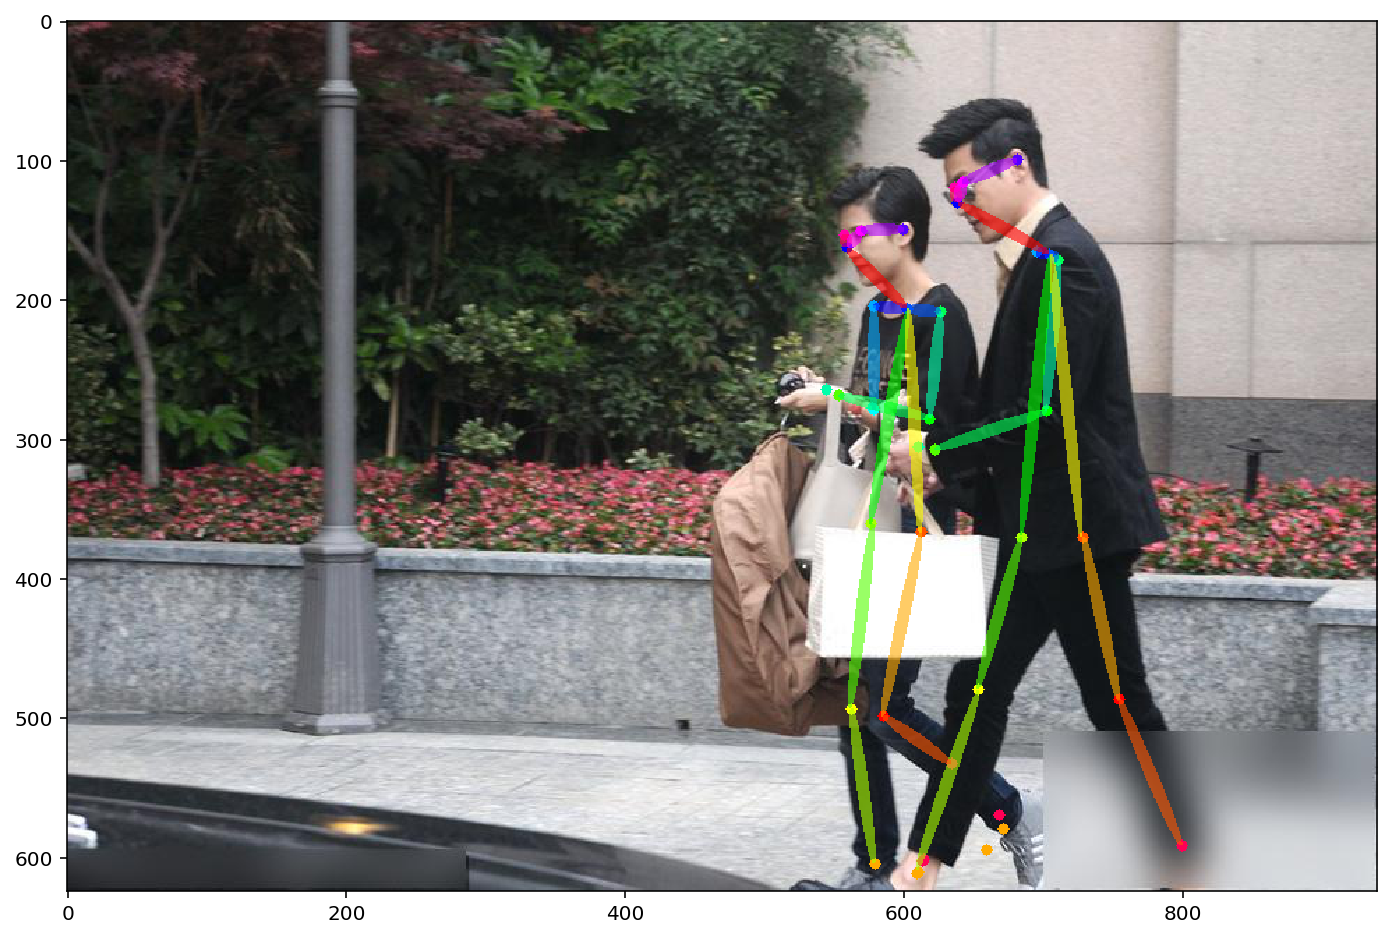

In [13]:
cv2.imwrite('result.png', img_canvas)   

plt.figure(figsize=(12, 8))
plt.imshow(img_canvas[...,::-1])